In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 18.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl
import matplotlib.pyplot as plt

In [98]:
file_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
data = pd.read_excel(file_path)
data = data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [99]:
secteurs = pd.unique(data["secteur"])

In [100]:
variables_env = ["scope_1", "scope_2", "scope_3", "waste_production", "waste_recycling", 
                 "water_consumption", "water_withdrawal", "energy_consumption"]

data = data.dropna(subset = ["employees"])
data = data.loc[data["employees"] != 0]
for v in variables_env :
    data[v] = data[v]/data["employees"]

In [104]:
def visualisation(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.groupby('company_id')[scope].mean().reset_index()
    mean = df[scope].mean()
    df = df[df[scope] <= mean*(1 + per)]
    df = df[df[scope] >= mean*(1 - per)]
    var = df[scope].var()
    new_mean = df[scope].mean()
    df[scope] = (df[scope]-new_mean)/np.sqrt(var)
    return df

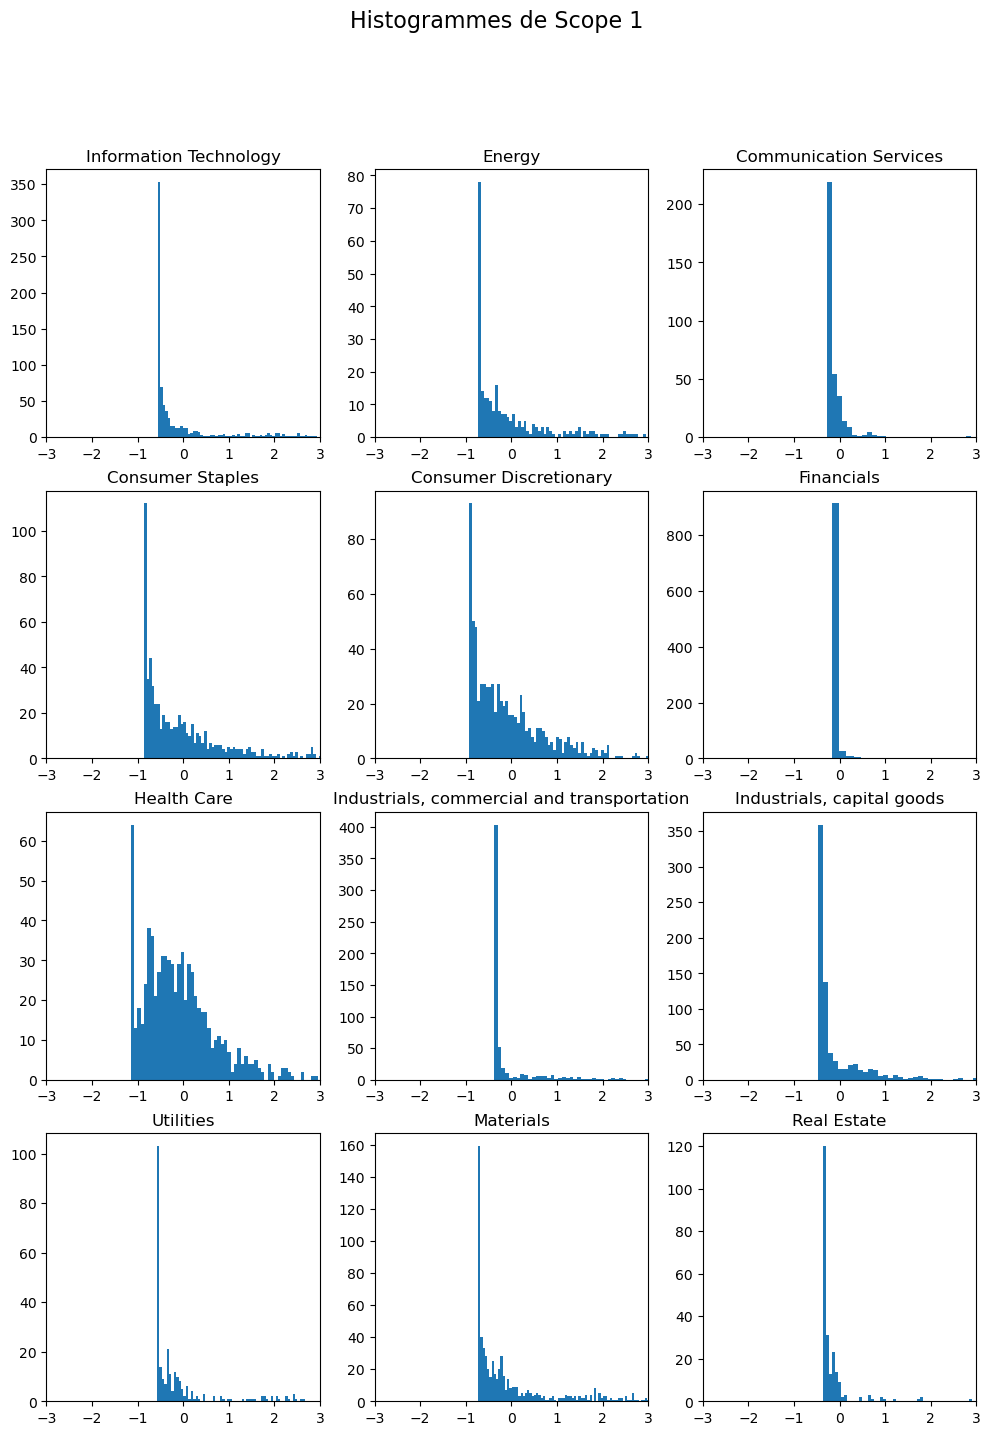

In [105]:
plt.figure(figsize=(12, 16))

i = 1
for s in secteurs :
    df = visualisation("scope_1", s, 1)
    plt.subplot(4,3,i)
    plt.hist(df["scope_1"], bins = 100)
    plt.title(s)
    plt.xlim([-3, 3])
    i += 1

plt.suptitle("Histogrammes de Scope 1", fontsize=16)
plt.show()

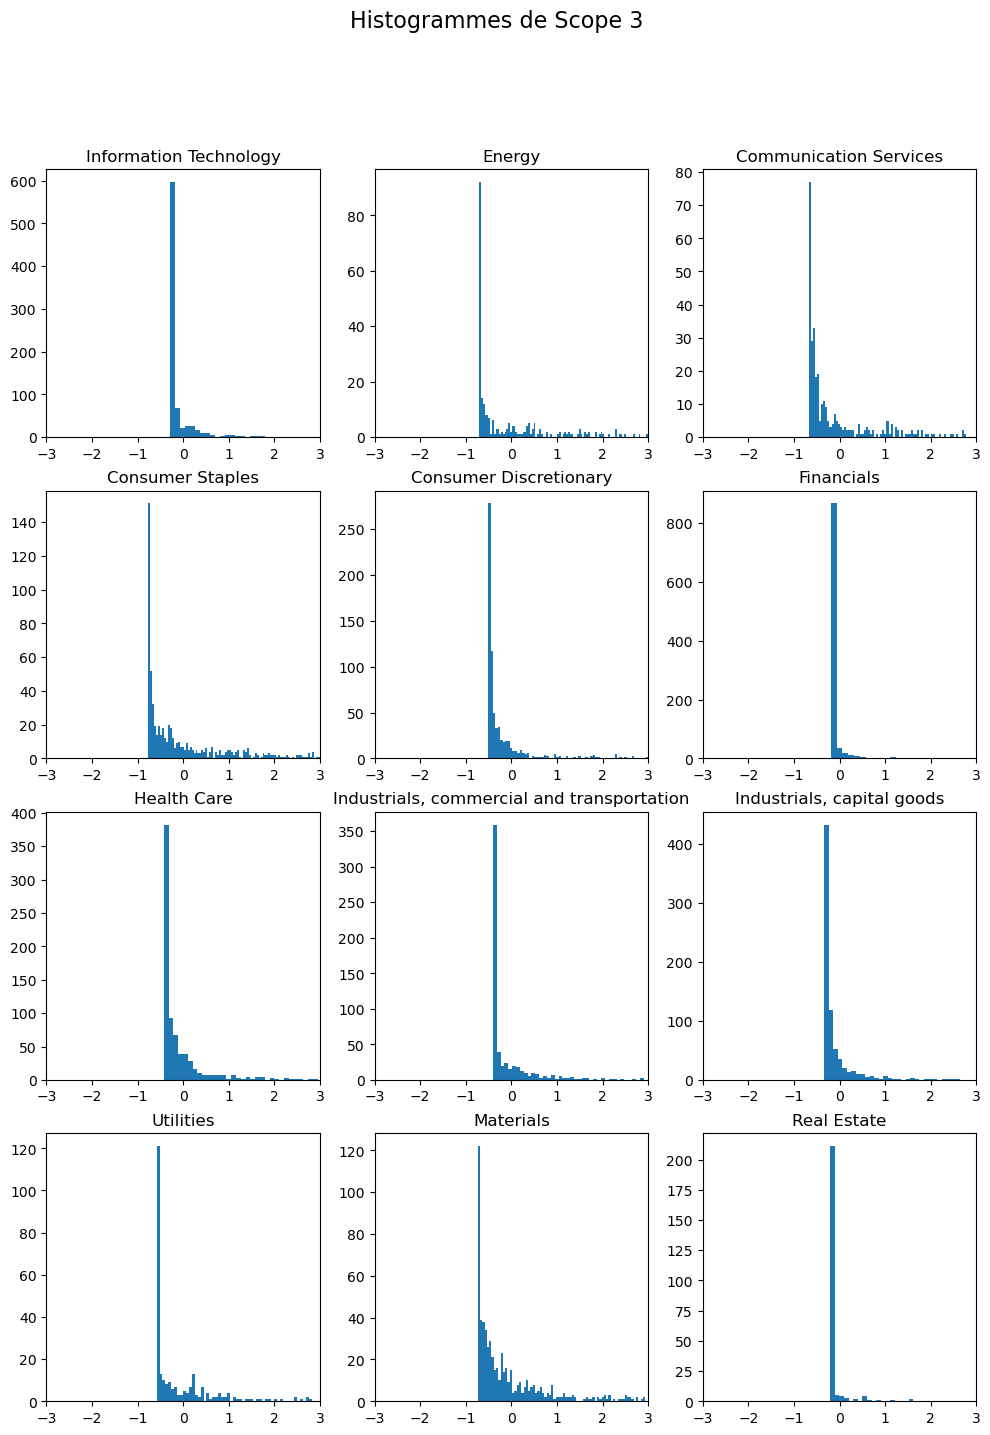

In [106]:
plt.figure(figsize=(12, 16))

i = 1
for s in secteurs :
    df = visualisation("scope_3", s, 1)
    plt.subplot(4,3,i)
    plt.hist(df["scope_3"], bins = 100)
    plt.title(s)
    plt.xlim([-3, 3])
    i += 1

plt.suptitle("Histogrammes de Scope 3", fontsize=16)
plt.show()

Il y a vraiment un gros pic proche de 0 (mais pas égal). Idée : mettre un threshold bas (genre comme précédemment on enlève les entreprises avec scope en dessous de P% de la moyenne, en prenant P égal à 0,01 typiquement, et refaire analyse moyenne, variance. 

Idée : relation entre taille de l'entreprise et "écart à la moyenne".

In [101]:
def visualisation2(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.groupby('company_id').agg({scope : 'mean', 'employees': 'mean'}).reset_index()
    quantile_90 = df[scope].quantile(1 - per)
    df = df[df[scope] <= quantile_90]
    
    mean = df[scope].mean()
    var = df[scope].var()
    df[scope] = (df[scope]-mean)/np.sqrt(var)
    return df

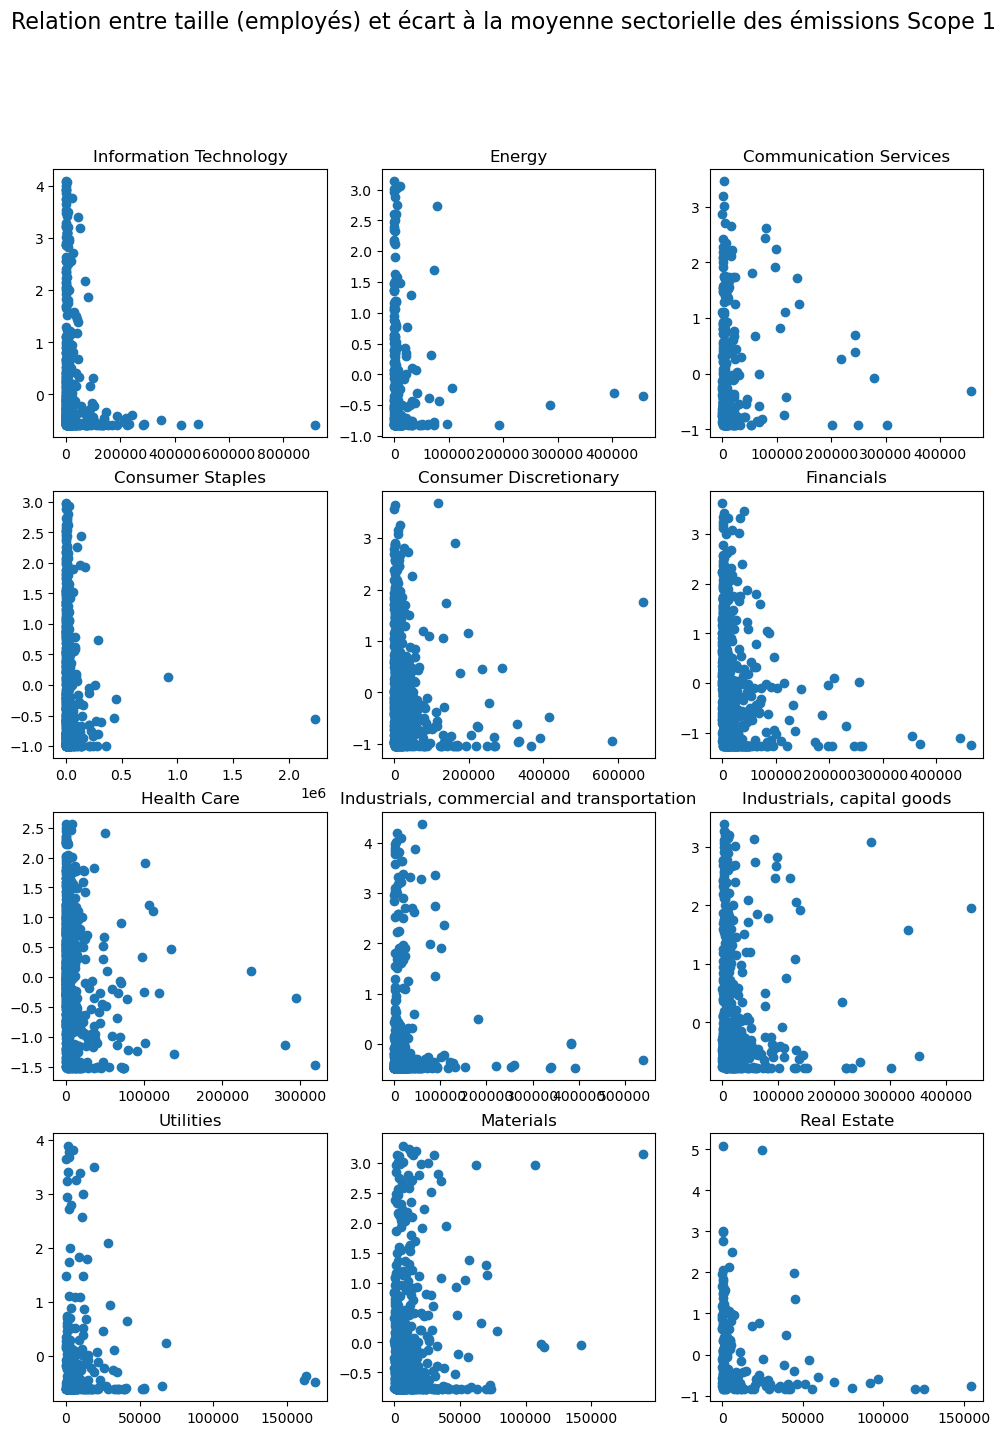

In [102]:
plt.figure(figsize=(12, 16))

i = 1
for s in secteurs :
    df = visualisation2("scope_1", s, 0.1)
    plt.subplot(4,3,i)
    plt.scatter(df["employees"], df["scope_1"])
    plt.title(s)
    #plt.xlim([-3, 3])
    i += 1

plt.suptitle("Relation entre taille (employés) et écart à la moyenne sectorielle des émissions Scope 1", fontsize=16)
plt.show()

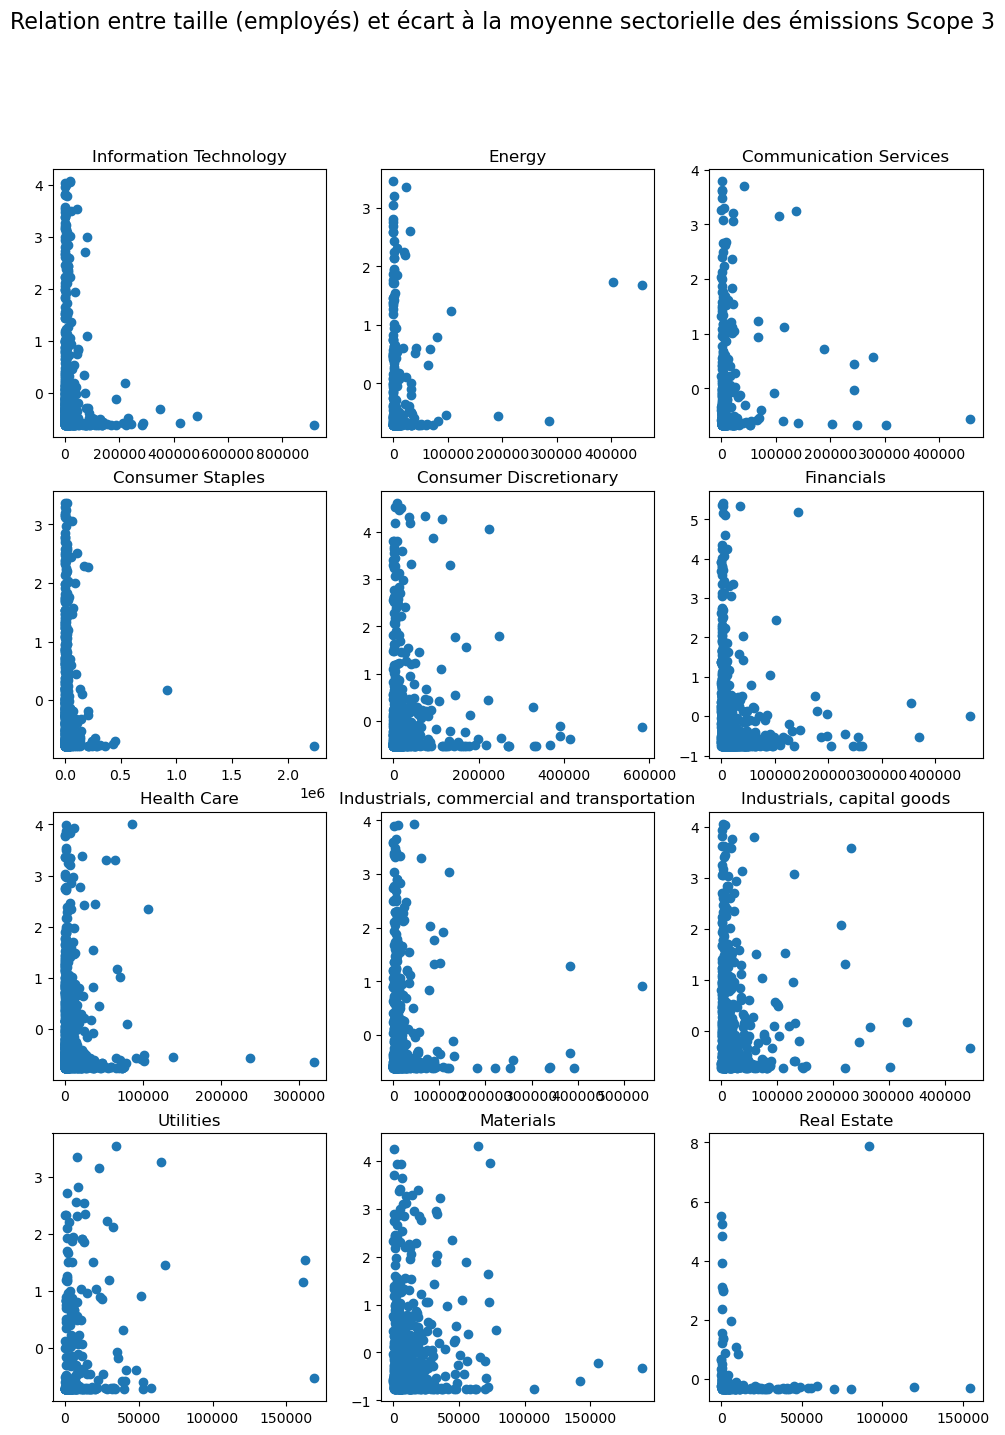

In [103]:
plt.figure(figsize=(12, 16))

i = 1
for s in secteurs :
    df = visualisation2("scope_3", s, 0.1)
    plt.subplot(4,3,i)
    plt.scatter(df["employees"], df["scope_3"])
    plt.title(s)
    #plt.xlim([-3, 3])
    i += 1

plt.suptitle("Relation entre taille (employés) et écart à la moyenne sectorielle des émissions Scope 3", fontsize=16)
plt.show()